<a href="https://colab.research.google.com/github/jhordi19/Ciencia_de_datos/blob/Taller/Taller_Sem07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Valoración de Riesgo de Hipertensión Modelo ML**

El dataset fue sacado de Kaggle el cual tiene el nombre de
[Hypertension Risk Prediction Dataset](https://www.kaggle.com/datasets/ankushpanday1/hypertension-risk-prediction-dataset/datahttps://)

✅ Instalación de Librerías Necesarias

In [ ]:
!pip install imbalanced-learn
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 MB 2.9 MB/s eta 0:00:00


📚 Importar Librerías autilizar

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from scipy.stats import randint,  uniform
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier

--------------------------------------------------------------------------

##🧩 1. Cargamos el Dataset

In [ ]:
df = pd.read_csv("hypertension_dataset.csv")

Identificamos la dimension del dataset

In [ ]:
df.shape

(174982, 23)

Seleccionamos las Columnas a utilizar

In [ ]:
cols = ['Gender', 'Age', 'BMI', 'Physical_Activity_Level', 'Sleep_Duration',
        'Smoking_Status', 'Family_History', 'Stress_Level', 'Hypertension']
df = df[cols]

--------------------------------------------------------------------------

##🧪 2. Preprocesamiento de Datos

Se codifican las variables categóricas y se escalan los datos numéricos.

In [ ]:
label_cols = ['Gender', 'Physical_Activity_Level', 'Smoking_Status', 'Family_History', 'Hypertension']
for col in label_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

Verificamos el tipo de dato

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174982 entries, 0 to 174981
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Gender                   174982 non-null  int64  
 1   Age                      174982 non-null  int64  
 2   BMI                      174982 non-null  float64
 3   Physical_Activity_Level  174982 non-null  int64  
 4   Sleep_Duration           174982 non-null  float64
 5   Smoking_Status           174982 non-null  int64  
 6   Family_History           174982 non-null  int64  
 7   Stress_Level             174982 non-null  int64  
 8   Hypertension             174982 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 12.0 MB


Verificamos si tiene nulos

In [ ]:
print("Valores nulos por columna:")
print(df.isnull().sum())

Valores nulos por columna:
Gender                     0
Age                        0
BMI                        0
Physical_Activity_Level    0
Sleep_Duration             0
Smoking_Status             0
Family_History             0
Stress_Level               0
Hypertension               0
dtype: int64


Separación de Variables predictivas de la Variable Objetivo 🎯

In [ ]:
X = df.drop('Hypertension', axis=1)
y = df['Hypertension']

🔄 Normlización de Datos

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

--------------------------------------------------------------------------

## ⚙ 3. Análisis Exploratorio - PCA y Clustering

🔹 Se realiza un PCA para visualizar la distribución de datos y un clustering con KMeans.

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

📌 Gráficamos la Distribución

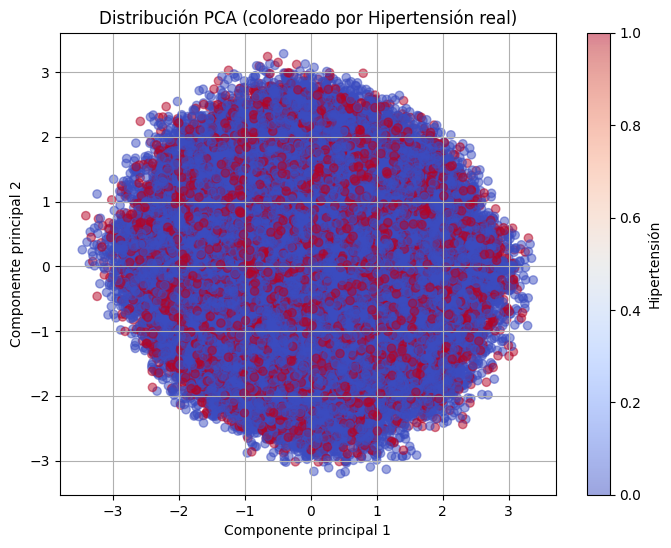

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.5)
plt.title("Distribución PCA (coloreado por Hipertensión real)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.colorbar(label='Hipertensión')
plt.grid(True)
plt.show()

🔹 KMeans clustering sobre datos escalados

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

📌 Gráfico Clustering (según KMeans)

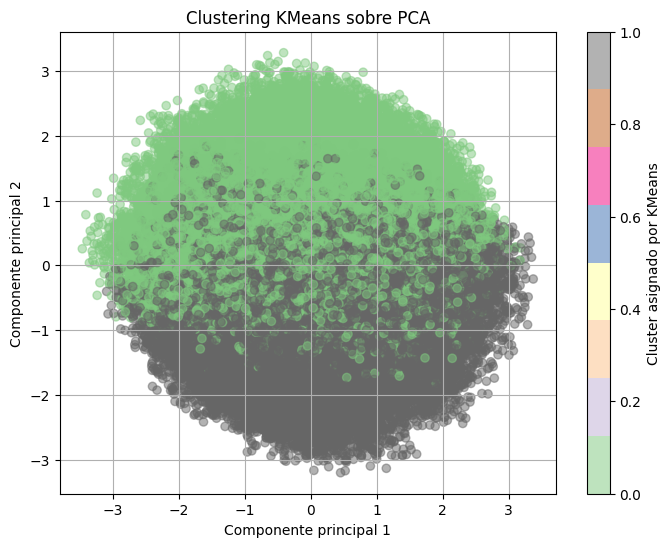

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='Accent', alpha=0.5)
plt.title("Clustering KMeans sobre PCA")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.colorbar(label='Cluster asignado por KMeans')
plt.grid(True)
plt.show()

🔹 Clustering jerárquico (solo para dendrograma)

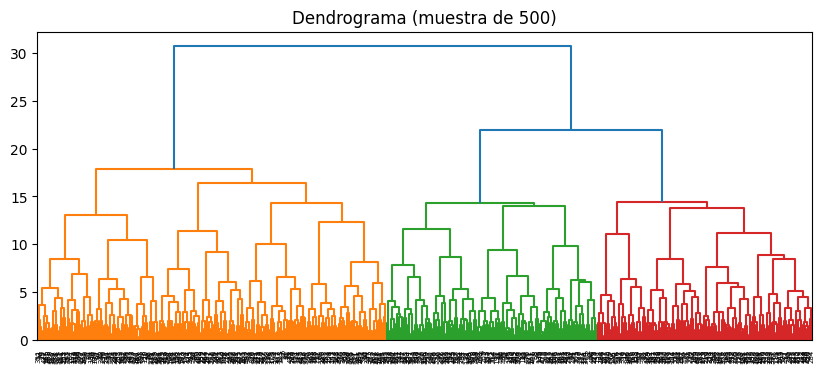

In [ ]:
linkage_matrix = linkage(X_scaled[:500], method='ward')
plt.figure(figsize=(10, 4))
dendrogram(linkage_matrix)
plt.title("Dendrograma (muestra de 500)")
plt.show()

## ⚖️ 4. Balanceo con SMOTE

Aplicamos SMOTE para poder balancear las clases minoritarias.

In [ ]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_scaled, y)

## 🤖 5. Entrenamiento de Modelos

###5.1 Random Forest

Se entrena un Random Forest con búsqueda aleatoria de hiperparámetros.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.1, random_state=42)

🔍 RANDOM SEARCH - Establecemos los Hiperparámetros

In [ ]:
param_dist = {
    'n_estimators': randint(100, 200),
    'max_depth': [20, None],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42
)


🚀 ENTRENAMIENTO

In [ ]:
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


 ## 6. 🧾 EVALUACIÓN


Visualización de métricas Clásicas y creación de curva ROC

In [ ]:
y_pred = best_model.predict(X_test)
print("✅ Mejores parámetros:", random_search.best_params_)
print("\n✅ Accuracy en validación cruzada:", random_search.best_score_)
print("\n✅ Classification Report:\n", classification_report(y_test, y_pred))
print("✅ Accuracy en test:", accuracy_score(y_test, y_pred))
print("✅ Matriz de confusión:\n", confusion_matrix(y_test, y_pred))

✅ Mejores parámetros: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 188}

✅ Accuracy en validación cruzada: 0.747094800690281

✅ Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.83      0.78     12489
           1       0.81      0.72      0.76     12668

    accuracy                           0.77     25157
   macro avg       0.77      0.77      0.77     25157
weighted avg       0.77      0.77      0.77     25157

✅ Accuracy en test: 0.7709186309973367
✅ Matriz de confusión:
 [[10328  2161]
 [ 3602  9066]]


📈 Visualización de Curva ROC

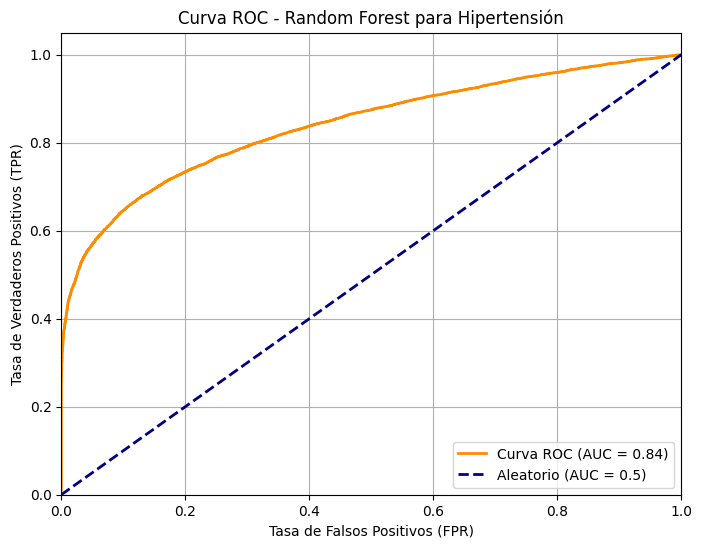

In [ ]:
y_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aleatorio (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Random Forest para Hipertensión')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## 🚀 5.2. Decision Tree

Aplicamos RandomizedSearchCV para la búsqueda de los mejores hiperparámetros, aplicando 10 folds y 15 iteraciones, dando un total de 150 fits

In [ ]:
# 🔍 Hiperparámetros para Decision Tree
param_dist = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 4, 6],
    "min_samples_leaf": [1, 2, 4],
    "max_features": [None, "sqrt", "log2"]
}

# 🎯 Entrenamiento con búsqueda aleatoria
random_search = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=15,
    cv=10,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

# 📊 Evaluación
y_pred_dt = best_model.predict(X_test)
print("✅ Mejores parámetros:", random_search.best_params_)
print("✅ Accuracy en test:", accuracy_score(y_test, y_pred_dt))
print("\n✅ Classification Report:\n", classification_report(y_test, y_pred_dt))
print("✅ Matriz de confusión:\n", confusion_matrix(y_test, y_pred_dt))

Fitting 10 folds for each of 15 candidates, totalling 150 fits
✅ Mejores parámetros: {'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': None, 'criterion': 'entropy'}
✅ Accuracy en test: 0.6966251937830424

✅ Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.73      0.71     12489
           1       0.71      0.66      0.69     12668

    accuracy                           0.70     25157
   macro avg       0.70      0.70      0.70     25157
weighted avg       0.70      0.70      0.70     25157

✅ Matriz de confusión:
 [[9128 3361]
 [4271 8397]]


## 🚀 5.3. XGBoost

Aplicamos RandomizedSearchCV para la búsqueda de los mejores hiperparámetros, aplicando 5 folds y 30 iteraciones, dando un total de 150 fits

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from scipy.stats import uniform, randint

# 🔍 Hiperparámetros para XGBoost
param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': [3, 5, 7, 10],
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 5)
}

# Búsqueda aleatoria
random_search = RandomizedSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Entrenamiento
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

# 📊 EVALUACIÓN
y_pred_xgb = best_model.predict(X_test)
print("✅ Mejores parámetros:", random_search.best_params_)
print("✅ Accuracy en test:", accuracy_score(y_test, y_pred_xgb))
print("\n✅ Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("✅ Matriz de confusión:\n", confusion_matrix(y_test, y_pred_xgb))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:28:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Mejores parámetros: {'colsample_bytree': np.float64(0.7219125032632117), 'gamma': np.float64(0.8232792657147087), 'learning_rate': np.float64(0.1702268258126326), 'max_depth': 5, 'n_estimators': 264, 'subsample': np.float64(0.8769744131561081)}
✅ Accuracy en test: 0.7552172357594308

✅ Classification Report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80     12489
           1       1.00      0.51      0.68     12668

    accuracy                           0.76     25157
   macro avg       0.83      0.76      0.74     25157
weighted avg       0.84      0.76      0.74     25157

✅ Matriz de confusión:
 [[12480     9]
 [ 6149  6519]]


📈 Visualización de Curva ROC

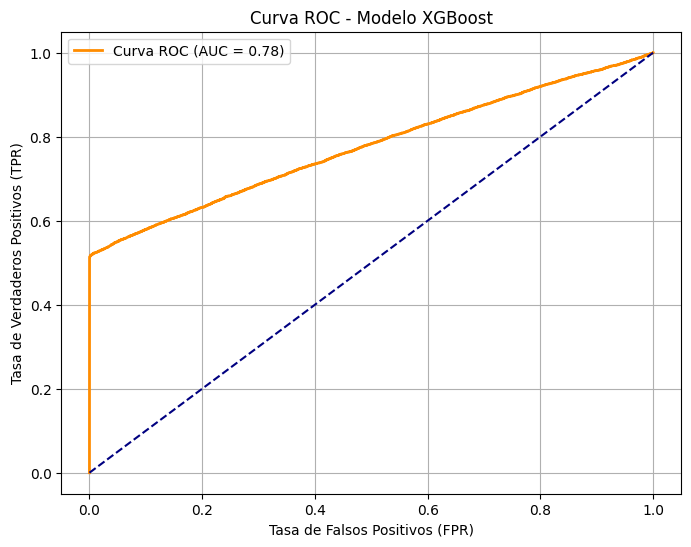

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# CURVA ROC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Obtener probabilidades de clase positiva
y_proba = best_model.predict_proba(X_test)[:, 1]

# Calcular FPR, TPR y umbrales
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr,tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title("Curva ROC - Modelo XGBoost")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.grid(True)
plt.legend()
plt.show()

Calculamos la métrica para cada umbral y verificamos cual es el más óptimo

    Umbral  Precision    Recall  F1-Score
0     0.10   0.503558  1.000000  0.669822
1     0.15   0.503538  0.999921  0.669786
2     0.20   0.503742  0.998816  0.669719
3     0.25   0.505718  0.991475  0.669795
4     0.30   0.523084  0.950742  0.674866
5     0.35   0.595517  0.809599  0.686250
6     0.40   0.789185  0.614067  0.690699
7     0.45   0.980074  0.524155  0.683022
8     0.50   0.998621  0.514604  0.679204
9     0.55   0.999846  0.511288  0.676590
10    0.60   1.000000  0.505763  0.671769
11    0.65   1.000000  0.496211  0.663290
12    0.70   1.000000  0.479634  0.648314
13    0.75   1.000000  0.456978  0.627296
14    0.80   1.000000  0.426745  0.598207
15    0.85   1.000000  0.391301  0.562496
16    0.90   1.000000  0.343780  0.511661


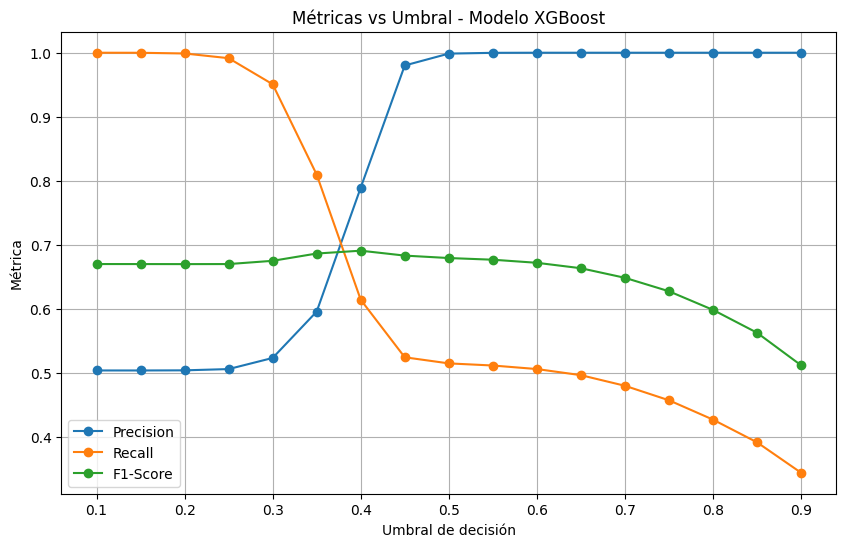

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Obtener probabilidades del modelo
y_proba = best_model.predict_proba(X_test)[:, 1]

# Definir lista de umbrales a evaluar
umbrales = np.arange(0.1, 0.91, 0.05)
resultados = []

# Calcular métricas para cada umbral
for u in umbrales:
    y_pred_u = (y_proba >= u).astype(int)
    precision = precision_score(y_test, y_pred_u)
    recall = recall_score(y_test, y_pred_u)
    f1 = f1_score(y_test, y_pred_u)
    resultados.append([u, precision, recall, f1])

# Crear DataFrame
df_resultados = pd.DataFrame(resultados, columns=['Umbral', 'Precision', 'Recall', 'F1-Score'])

# Mostrar tabla
print(df_resultados)

# Visualizar gráficamente
plt.figure(figsize=(10, 6))
plt.plot(df_resultados['Umbral'], df_resultados['Precision'], label='Precision', marker='o')
plt.plot(df_resultados['Umbral'], df_resultados['Recall'], label='Recall', marker='o')
plt.plot(df_resultados['Umbral'], df_resultados['F1-Score'], label='F1-Score', marker='o')
plt.xlabel("Umbral de decisión")
plt.ylabel("Métrica")
plt.title("Métricas vs Umbral - Modelo XGBoost")
plt.grid(True)
plt.legend()
plt.show()


Observando el Gráfico, el umbral quenos brinda resultados más balanceados es el 0.4

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# 🔹 Obtener probabilidades
y_proba = best_model.predict_proba(X_test)[:, 1]

# 🔹 Aplicar nuevo umbral
nuevo_umbral = 0.40
y_pred_xgb_ajustado = (y_proba >= nuevo_umbral).astype(int)

# 🔹 Evaluar con nuevo umbral
print(f"✅ Resultados con umbral ajustado a {nuevo_umbral}:\n")
print("🔸 Accuracy:", accuracy_score(y_test, y_pred_xgb_ajustado))
print("🔸 Classification Report:\n", classification_report(y_test, y_pred_xgb_ajustado))
print("🔸 Matriz de Confusión:\n", confusion_matrix(y_test, y_pred_xgb_ajustado))


✅ Resultados con umbral ajustado a 0.4:

🔸 Accuracy: 0.7230591882974917
🔸 Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.83      0.75     12489
           1       0.79      0.61      0.69     12668

    accuracy                           0.72     25157
   macro avg       0.73      0.72      0.72     25157
weighted avg       0.74      0.72      0.72     25157

🔸 Matriz de Confusión:
 [[10411  2078]
 [ 4889  7779]]


## 📊 7. Comparación de Modelos desarrollados

Finalmente realizamos un gráfico comparando las métricas de los modelos desarrollados observando:
- Accuracy
- Precision
- Recall
- F1-Score

📊 Métricas comparadas:


,Accuracy,Precision,Recall,F1-Score
Random Forest,0.770919,0.774705,0.770919,0.770259
Decision Tree,0.696625,0.697816,0.696625,0.696306
XGBoost,0.723059,0.735208,0.723059,0.719786


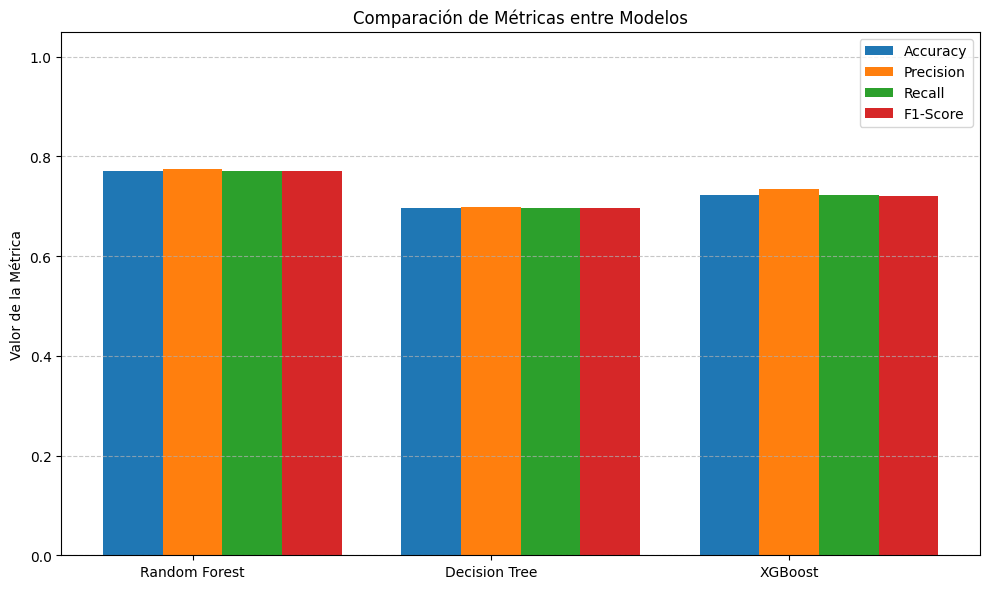

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt

# Calcular métricas para cada modelo
metricas = {
    "Random Forest": {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1-Score": f1_score(y_test, y_pred, average='weighted')
    },
    "Decision Tree": {
        "Accuracy": accuracy_score(y_test, y_pred_dt),
        "Precision": precision_score(y_test, y_pred_dt, average='weighted'),
        "Recall": recall_score(y_test, y_pred_dt, average='weighted'),
        "F1-Score": f1_score(y_test, y_pred_dt, average='weighted')
    },
    "XGBoost": {
        "Accuracy": accuracy_score(y_test, y_pred_xgb_ajustado),
        "Precision": precision_score(y_test, y_pred_xgb_ajustado, average='weighted'),
        "Recall": recall_score(y_test, y_pred_xgb_ajustado, average='weighted'),
        "F1-Score": f1_score(y_test, y_pred_xgb_ajustado, average='weighted')
    }
}

# Crear DataFrame
df_metricas = pd.DataFrame(metricas).T

# Mostramos las métricas
print("📊 Métricas comparadas:")
display(df_metricas)

# Creamos el gráfico de barras agrupadas
labels = df_metricas.index
metricas_names = df_metricas.columns
x = np.arange(len(labels))
width = 0.2

plt.figure(figsize=(10, 6))
for i, metrica in enumerate(metricas_names):
    plt.bar(x + i * width, df_metricas[metrica], width=width, label=metrica)

plt.xticks(x + width, labels)
plt.ylim(0, 1.05)
plt.ylabel("Valor de la Métrica")
plt.title("Comparación de Métricas entre Modelos")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
